# Сводка

Ссылка на тестовое задание: https://docs.google.com/document/d/1F3tKzkYt2GDDR9T53kyOg2oYYGndh60nfYQXMa0t1HY/edit?usp=sharing

Цели (1/1): Построение анализатора тональности обзоров Steam на основе заданного корпуса текстов

Задачи (11/11)

Дополнительные задачи (0/2)

# Ипорты

In [1]:
from os import listdir
from os.path import isfile, join
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

import collections
import re

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Предобработка данных

## Считывание данных и разделение на две выборки

In [2]:
def get_reviews():
    """
    Читает данные из папки Google Drive Colab Notebooks/ReviewSimpleClassifier/
    и возвращает датафрейм только с текстом ревью и оценкой
    """
    data = pd.read_csv('drive/MyDrive/Colab Notebooks/ReviewSimpleClassifier/FallGuysSteamReviews.csv')
    reviews = data[["review", "voted_up"]]
    return reviews


def get_clean_data(df, min_lenght = 3):
    """
    Возвращает датафрейм
    Чистка от слишком коротких ревью
    """
    new_df = df[df["review"].map(lambda x: len(str(x))) >= min_lenght]
    return new_df


In [3]:
data = get_clean_data(get_reviews())

data_vu = data[data['voted_up']].iloc[:10000]
data_vd = data[data['voted_up'] == False].iloc[:10000]

train_source = pd.concat([data_vu.iloc[:7000], data_vd.iloc[:7000]], ignore_index=True)
test_source = pd.concat([data_vu.iloc[7000:], data_vd.iloc[7000:]], ignore_index=True)

print("Доля позитивных обзоров в обучающей выборке", 
      len(train_source[train_source["voted_up"]==True])/len(train_source))
print("Доля позитивных обзоров в тестовой выборке", 
      len(test_source[test_source["voted_up"]==True])/len(test_source))


Доля позитивных обзоров в обучающей выборке 0.5
Доля позитивных обзоров в тестовой выборке 0.5


## Токенизация и чистка от стоп-слов

In [4]:
def get_stopwords():
    """
    Возвращает список стоп-слов
    Считывает информацию из Google Drive Colab Notebooks/ReviewSimpleClassifier/
    """
    stopwords = []
    with open('drive/MyDrive/Colab Notebooks/ReviewSimpleClassifier/stopwords.txt') as source:
        stopwords = [line.replace('\n', '') for line in source.readlines()]
    return stopwords


def tokenize_text_simple_regex(text, min_token_size=2, stopwords=None):
    """
    Возвращает list с токенизированным на основе регулярного выражения 
    и списка стоп-слов текстом
    """
    TOKEN_RE = re.compile(r'[\w\d]+')
    if stopwords is None:
        stopwords = get_stopwords()

    text = str(text).lower()
    all_tokens = TOKEN_RE.findall(text)
    return [token for token in all_tokens if len(token) >= min_token_size and not token in stopwords]


In [5]:
# TODO: Использовать .loc[] для работы с датафреймами, чтобы возвращать 
# представление, а не копию, так как пандас ругается
train_source["review"] = train_source["review"].apply(tokenize_text_simple_regex)
test_source["review"] = test_source["review"].apply(tokenize_text_simple_regex)

train_tokenized = get_clean_data(train_source)
test_tokenized = get_clean_data(test_source)

print("Число записей в токенизированной обучающей выборке", len(train_tokenized["review"]))
print("Число записей в токенизированной тестовой выборке", len(test_tokenized["review"]))

Число записей в токенизированной обучающей выборке 13924
Число записей в токенизированной тестовой выборке 5978


## Построение словаря токенов

In [6]:
def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    """
    Возвращает словарь и NumPy массив с нормированными частотами слов
    """
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


Мы будем отсеивать те слова, которые встречаются менее 5 раз, а также те, которые встречаются в 80 или более процентах текстов

In [7]:
MAX_DF = 0.8
MIN_COUNT = 5

vocabulary, word_doc_freq = build_vocabulary(train_tokenized["review"].tolist(), max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print("Первые 10 наиболее частых токенов в словаре\n", list(vocabulary.items())[:10])

Количество уникальных токенов 3285
Первые 10 наиболее частых токенов в словаре
 [('game', 0), ('fun', 1), ('good', 2), ('play', 3), ('hackers', 4), ('cheaters', 5), ('get', 6), ('games', 7), ('like', 8), ('time', 9)]


## Гистограмма для распределения относительных частот слов. 

Закон Ципфа выполняется.

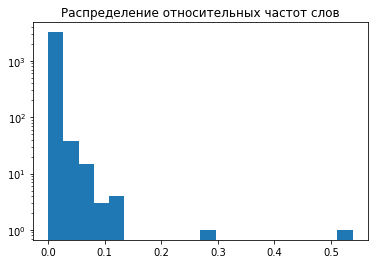

In [8]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

## Удаление текстов, в которых нет ни одного токена.

Вынуждены пожертвовать частью данных, в которых не обнаруживается токенов из словаря, так как в противном случае у нас появится множество пустых (с точки зрения полезной информации) строк, которые каким-то образом должны приводить классификатор к различным результатам.


In [9]:
def has_token_in_text(tokenized_data, vocabulary):
    """
    Возвращает list bool'ов с информацией, имеется ли в тексте токенизированного 
    датафрейма хотя бы один токен из сформированного словаря
    """
    # TODO: Использовать .loc[] для работы с датафреймами, чтобы возвращать 
    # представление, а не копию, так как пандас ругается
    has_token = []
    for index, row in tokenized_data.iterrows():
        is_token = False
        for token in list(vocabulary.keys()):
            if token in row['review']:
                is_token = True
                break;
        has_token += [is_token]
    return has_token


train_tokenized['has_token'] = has_token_in_text(train_tokenized, vocabulary)
train_tokenized = train_tokenized[train_tokenized['has_token'] == True]

test_tokenized['has_token'] = has_token_in_text(test_tokenized, vocabulary)
test_tokenized = test_tokenized[test_tokenized['has_token'] == True]

print("Число записей в обучающей выборке после удаления текстов",
      "без токенов из словаря =", len(train_tokenized["review"]))
print("Число записей в тестовой выборке после удаления текстов",
      "без токенов из словаря =", len(test_tokenized["review"]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Число записей в обучающей выборке после удаления текстов без токенов из словаря = 13322
Число записей в тестовой выборке после удаления текстов без токенов из словаря = 5694


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Построение матрицы признаков

In [10]:
def vectorize_texts(tokenized_texts, word2id, word2freq, scale=True):
    """
    Возвращает разряженную отмасштабированную (опционально) матрицу с TFIDF
    """
    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    result = result.tocsr()
    result = result.multiply(1 / result.sum(1))  # TF
    result = result.multiply(1 / word2freq)  # TFIDF

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()


In [11]:
train_vectors = vectorize_texts(train_tokenized["review"].tolist(), vocabulary, word_doc_freq)
test_vectors = vectorize_texts(test_tokenized["review"].tolist(), vocabulary, word_doc_freq)

UNIQUE_LABELS_N = len(set(train_source['voted_up']))

## Результаты, графики, информация об обработанных данных

In [12]:
print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)

print('\nКоличество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))

print('\nКоличество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

print('\nКоличество уникальных меток', UNIQUE_LABELS_N)

Размерность матрицы признаков обучающей выборки (13322, 3285)
Размерность матрицы признаков тестовой выборки (5694, 3285)

Количество ненулевых элементов в обучающей выборке 168166
Процент заполненности матрицы признаков 0.38%

Количество ненулевых элементов в тестовой выборке 74488
Процент заполненности матрицы признаков 0.40%

Количество уникальных меток 2


Используются разряженные матрицы из-за большого числа нулей в векторе с данными. Это позволяет экономить память.

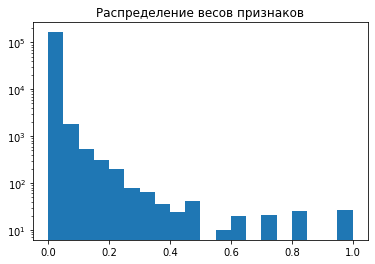

In [13]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


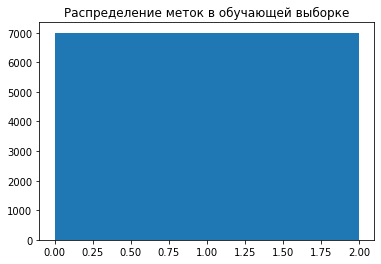

In [14]:
plt.hist(train_source['voted_up'], bins=np.arange(0, 3))
plt.title('Распределение меток в обучающей выборке');

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


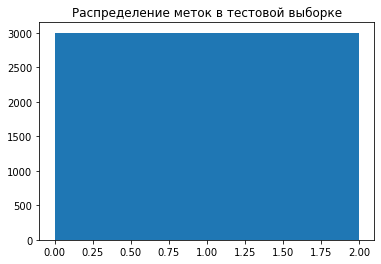

In [15]:

plt.hist(test_source['voted_up'], bins=np.arange(0, 3))
plt.title('Распределение меток в тестовой выборке');

# Модель и её обучение

## sklearn.linear_model.LogisticRegression()

In [16]:
from sklearn.linear_model import LogisticRegression
train_classes = [1 if x else 0 for x in train_tokenized['voted_up'].tolist()]
clf = LogisticRegression(random_state=0)
clf.fit(train_vectors, train_classes)

test_classes = [1 if x else 0 for x in test_tokenized['voted_up'].tolist()]
clf.predict(test_vectors)
clf.predict_proba(test_vectors)
print("Точность классификации на тестовой выборе =",clf.score(test_vectors, test_classes))

Точность классификации на тестовой выборе = 0.5361784334387074


Надо заметить, что большая ошибка обусловлена выбором Логистической Регрессии как способа классификации. Скорее всего, наши классы линейно неразделимы.

# Оценка качества классификации

In [17]:
# TODO: Придумать нормальное имя для таблицы контингентности
def get_table(test_classes, predicted_classes, target_class_value):
    table = {'True-Positive': 0,
             'False-Positive': 0,
             'False-Negative': 0,
             'True-Negative': 0}
    for i in range(len(test_classes)):
        if predicted_classes[i] == target_class_value and test_classes[i] == target_class_value:
            table['True-Positive'] += 1
        elif predicted_classes[i] == target_class_value and test_classes[i] != target_class_value:
            table['False-Positive'] += 1
        elif predicted_classes[i] != target_class_value and test_classes[i] == target_class_value:
            table['False-Negative'] += 1
        else:
            table['True-Negative'] += 1
    return table

Для начала получим таблицу контингентности для каждого класса (0 - негативный обзор, 1 - позитивный обзор)

In [18]:
predicted_classes = list(clf.predict(test_vectors))

vote_down_class = get_table(test_classes, predicted_classes, 0)
vote_up_class = get_table(test_classes, predicted_classes, 1)

print(vote_down_class)
print(vote_up_class)

{'True-Positive': 2911, 'False-Positive': 2618, 'False-Negative': 23, 'True-Negative': 142}
{'True-Positive': 142, 'False-Positive': 23, 'False-Negative': 2618, 'True-Negative': 2911}


Вычисление значений точности, полноты и F-меры для каждого класса:

In [30]:
def get_precision(contingency_table):
    """
    Возвращает целое значение - точность. Она показывает долю документов
    действительно принадлежащих классу среди всех документов, которые 
    система отнесла к данному классу
    """
    return contingency_table['True-Positive']/(contingency_table['True-Positive'] + contingency_table['False-Positive'])


def get_recall(contingency_table):
    """
    Возвращает целое значение - полноту. Она показывает долю найденных классификатором
    документов принадлежащих данному классу относительно всех документов
    этого класса в тестовой выборке
    """
    return contingency_table['True-Positive']/(contingency_table['True-Positive'] + contingency_table['False-Negative'])


def get_f_measure(precision, recall):
    """
    Возвращает целое значение - F-меру. Она объединяет информацию о точности
    и полноте и представляет собой гармоническое среднее между ними
    """
    return 2 * (precision * recall)/(precision + recall)


In [31]:
precision_vd = get_precision(vote_down_class)
recall_vd = get_recall(vote_down_class)
f_measure_vd = get_f_measure(precision_vd, recall_vd)

precision_vu = get_precision(vote_up_class)
recall_vu = get_recall(vote_up_class)
f_measure_vu = get_f_measure(precision_vu, recall_vu)

In [32]:
print("Качество классификации негативных обзоров:")
print(f'Точность {precision_vd:.4f}')
print(f'Полнота {recall_vd:.4f}')
print(f'F-мера {f_measure_vd:.4f}')

print('\nКачество классификации позитивных обзоров:')
print(f'Точность {precision_vu:.4f}')
print(f'Полнота {recall_vu:.4f}')
print(f'F-мера {f_measure_vu:.4f}')

Качество классификации негативных обзоров:
Точность 0.5265
Полнота 0.9922
F-мера 0.6879

Качество классификации позитивных обзоров:
Точность 0.8606
Полнота 0.0514
F-мера 0.0971
